In [82]:
import uproot as ur
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import re
from tqdm import tqdm

import sys, pathlib
sys.path.append(str(pathlib.Path.cwd().parent / "src"))

import leCroyParser.leCroyParser as lcp     


In [83]:
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

OUTPUT_DIR = os.path.join(PROJECT_ROOT, "output")
DATA_DIR = os.path.join(PROJECT_ROOT, "data")
FIG_DIR = os.path.join(PROJECT_ROOT, "figs")

os.makedirs(FIG_DIR, exist_ok=True)

In [84]:
power = 80.0
idx = 0

In [85]:
def get_latest_run_dir(power, base_path=OUTPUT_DIR):
    pattern = os.path.join(base_path, f"run_*_Power_{power}%")
    run_dirs = sorted(glob.glob(pattern))
    if not run_dirs:
        raise FileNotFoundError(f"No run dir for Power={power}%")
    return run_dirs[-1]  # latest by name (timestamped)
get_latest_run_dir(power, OUTPUT_DIR)

latest_TRCDir = get_latest_run_dir(power, OUTPUT_DIR)
latest_TRCDir = os.path.join(latest_TRCDir, "raw")
TRC_files = sorted(os.listdir(latest_TRCDir))
TRC_file_paths = sorted(glob.glob(os.path.join(latest_TRCDir, "*.trc")))

print(TRC_files)

['C1--Trace1.trc', 'C2--Trace1.trc', 'C3--Trace1.trc', 'C4--Trace1.trc', 'C5--Trace1.trc', 'C6--Trace1.trc', 'C7--Trace1.trc']


In [86]:
sd = lcp.ScopeData(TRC_file_paths[0])

In [87]:
import numpy as np
from leCroyParser.leCroyParser import ScopeData
import glob, os

def load_run_segments(raw_dir):
    """
    raw_dir : directory that contains
        C1--Trace1.trc … C7--Trace1.trc   (each file already holds 1 000 segments)

    Returns
        t_seg  : (nseg,  nsamp)               time axis per segment   [s]
        y_seg  : (nchan, nseg, nsamp)         voltages                [V]
        ch_ids : list of channel numbers      e.g. [1,2,3,4,5,6,7]
    """
    # ---- discover files ----------------------------------------------------
    trc_paths = sorted(glob.glob(os.path.join(raw_dir, "C*--Trace1.trc")))
    if not trc_paths:
        raise FileNotFoundError("No C*--Trace1.trc files in " + raw_dir)

    channel_numbers = [int(os.path.basename(p)[1]) for p in trc_paths]  # 1…8
    voltages = []
    nseg = nsamp = None

    # ---- loop over each channel file ---------------------------------------
    for p in trc_paths:
        sd = ScopeData(p)                     # parse ONE file, one channel
        if nseg is None:
            nseg  = int(sd.sequenceSegments)
            total = sd.y.size
            nsamp = total // nseg
            t_seg = np.asarray(sd.x, float)[:nseg*nsamp].reshape(nseg, nsamp)

        # reshape voltage for this channel
        y = np.asarray(sd.y, float)[:nseg*nsamp].reshape(nseg, nsamp)
        voltages.append(y)

    # stack → (nchan, nseg, nsamp)
    y_seg = np.stack(voltages, axis=0)
    return t_seg, y_seg, channel_numbers
raw_dir = "/home/arcadia/FCFD-Laser/output/run_20250922_142045_Power_80.0%/raw"
t_seg, y_seg, chans = load_run_segments(raw_dir)

print("Shapes:", t_seg.shape, y_seg.shape)   # (1000, nsamp)  (7,1000,nsamp)

# Plot segment 0 for all channels
import matplotlib.pyplot as plt
for idx, ch in enumerate(chans):
    plt.plot(t_seg[0]*1e9, y_seg[idx, 0], label=f"C{ch}")
plt.xlabel("Time [ns]"); plt.ylabel("V"); plt.legend(ncol=4); plt.show()


FileNotFoundError: No C*--Trace1.trc files in /home/arcadia/FCFD-Laser/output/run_20250922_142045_Power_80.0%/raw

In [74]:
t, v = sd.x, sd.y
print(t.shape, v.shape)

(5002000,) (5002000,)


In [75]:
min([t.size] + [y.size for y in v])

1

In [76]:
t_seg, v_seg = split_segments(sd)         # t_seg = 1-D, v_seg = (1000,n)

# plot segment 0 and 1
plt.plot(t_seg*1e6, v_seg[0], label="seg 0")
plt.plot(t_seg*1e6, v_seg[1], label="seg 1")
plt.legend(); plt.xlabel("time [µs]"); plt.show()

nseg=1000, nsamp=5002, total=5002000


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

[-2.50084401e-07 -2.49984401e-07 -2.49884401e-07 -2.49784401e-07
 -2.49684401e-07] [0.00048828 0.00453404 0.00502232 0.00216239 0.00013951]
samples: 5002000


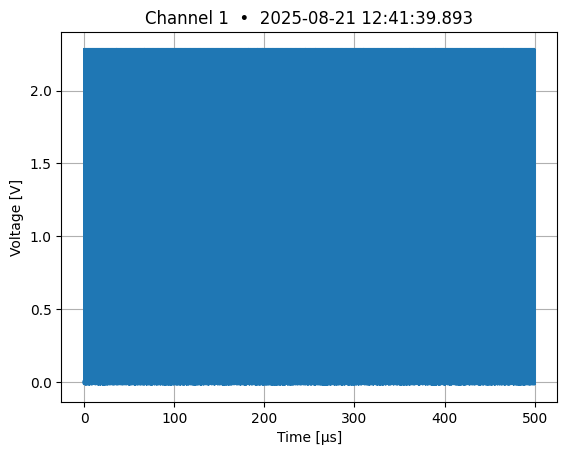

In [39]:
print(t[:5], v[:5])            # inspect
print("samples:", v.size)

plt.plot(t*1e6, v)             # convert time axis to µs for readability
plt.xlabel("Time [µs]")
plt.ylabel("Voltage [V]")
plt.title(data.waveSource + "  •  " + data.triggerTime)
plt.grid()
plt.show()